<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TERM3/AI_at_Scale/Assignments/Assignment2/Assignment2U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install pyspark pandas imbalanced-learn

Use the Bank Marketing dataset (saved in drive) to build a binary
classifier that predicts whether a customer will subscribe to a term deposit
using Spark MLlib.


Do the following tasks on the dataset:


Problem 1 : Data Understanding (Marks : 10)

In [19]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import regexp_replace, col, countDistinct, col, sum
from pyspark.sql.types import StringType, DoubleType, IntegerType ,StructType,StructField
from pyspark.ml.feature import Imputer, VectorAssembler,StandardScaler
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
import time
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml import PipelineModel

In [20]:
import csv

def sniff_delimiter(file_path):
    with open(file_path, 'r') as f:
        # Read a sample of the file
        sample = f.read(4096)
        # Use the sniffer to guess the delimiter
        sniffer = csv.Sniffer()
        try:
            dialect = sniffer.sniff(sample)
            return dialect.delimiter
        except csv.Error:
            return "Could not determine delimiter automatically. Please inspect the file manually."

file_path = 'bank-full.csv'
delimiter = sniff_delimiter(file_path)
print(f"Detected delimiter: {delimiter}")

Detected delimiter: ;


In [40]:
def get_schema():
    return StructType([
    StructField("age", IntegerType(), True),
    StructField("job", StringType(), True),
    StructField("marital", StringType(), True),
    StructField("education", StringType(), True),
    StructField("default", StringType(), True),
    StructField("balance", DoubleType(), True),
    StructField("housing", StringType(), True),
    StructField("loan", StringType(), True),
    StructField("contact", StringType(), True),
    StructField("day", IntegerType(), True),
    StructField("month", StringType(), True),
    StructField("duration", IntegerType(), True),
    StructField("campaign", IntegerType(), True),
    StructField("pdays", IntegerType(), True),
    StructField("previous", IntegerType(), True),
    StructField("poutcome", StringType(), True),
    StructField("y", StringType(), True)

])

In [42]:
# Load the dataset and print schema
def create_spark_session(executor_cores="1", max_cores="2", executor_memory="1g"):
    return SparkSession.builder \
        .appName("Assignment2_ch24m571") \
        .config("spark.executor.cores", executor_cores) \
        .config("spark.cores.max", max_cores) \
        .config("spark.executor.memory", executor_memory) \
        .config("spark.driver.memory", "2g") \
        .getOrCreate()
# spark_c = SparkSession.builder \
#     .appName("Assignment2") \
#     .config("spark.executor.cores","2") \
#     .config("spark.executor.memory", "1g") \
#     .config("spark.driver.memory", "2g") \
#     .getOrCreate()

# data = spark_c.read.csv("bank-full.csv", header=True, schema=customSchema, sep=';')
# data.printSchema()

In [23]:
# data.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no| 2143.0|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|   29.0|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|    2.0|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no| 1506.0|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|    1.0|     no|  no|unknown|  5|  may

In [24]:
# Count how many customers subscribed (y = yes) vs not.

subscription_counts = data.groupBy("y").count()
subscription_counts.show()


+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



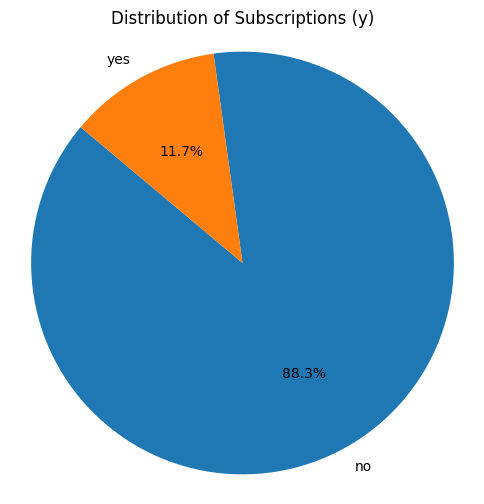

In [25]:

import matplotlib.pyplot as plt

# spark to pandas df
subscription_counts_pd = subscription_counts.toPandas()

# pie chart
plt.figure(figsize=(6, 6))
plt.pie(subscription_counts_pd['count'], labels=subscription_counts_pd['y'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Subscriptions (y)')
plt.axis('equal')
plt.show()


In [26]:
# Print the distinct values of job and education and count of each value

print("Distinct values and counts for 'job':")
data.groupBy("job").count().show(truncate=False)

print("Distinct values and counts for 'education':")
data.groupBy("education").count().show(truncate=False)

Distinct values and counts for 'job':
+-------------+-----+
|job          |count|
+-------------+-----+
|management   |9458 |
|retired      |2264 |
|unknown      |288  |
|self-employed|1579 |
|student      |938  |
|blue-collar  |9732 |
|entrepreneur |1487 |
|admin.       |5171 |
|technician   |7597 |
|services     |4154 |
|housemaid    |1240 |
|unemployed   |1303 |
+-------------+-----+

Distinct values and counts for 'education':
+---------+-----+
|education|count|
+---------+-----+
|unknown  |1857 |
|tertiary |13301|
|secondary|23202|
|primary  |6851 |
+---------+-----+



In [27]:
# split the data in train and test dataset and report distribution of output values in train and test dataset

train_df, test_df = data.randomSplit([.8, .2], seed=42)
print(f""" {train_df.count()} rows -> training set | {test_df.count()} -> test set""")

 36180 rows -> training set | 9031 -> test set


In [28]:
train_counts = train_df.groupBy("y").count().collect()
yes_count = [row['count'] for row in train_counts if row['y'] == 'yes'][0]
no_count = [row['count'] for row in train_counts if row['y'] == 'no'][0]
imbalance_ratio = no_count / yes_count
print(f"Imbalance ratio (no/yes): {imbalance_ratio:.2f}")

Imbalance ratio (no/yes): 7.45


Data is heavily imbalanced , hence need to balance

In [29]:
''' Use your favorite strategy to balance the dataset, if you find that data is imbalanced
and is important to balance the dataset before training the model. Provide
explanation of your decision. '''

def apply_smoteenc_balancing(spark,train_df):
  ''' since smoteenc works on pandas dataframe , we shall convert to pandas and work
  '''
  from imblearn.over_sampling import SMOTENC

  try:
    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = train_df.toPandas()

    # feature and target split

    feature_cols = [col for col in pandas_df.columns if col != 'y']
    X = pandas_df[feature_cols]
    y = pandas_df['y']

  # Identify categorical columns for SMOTENC
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
    categorical_indices = [X.columns.get_loc(col) for col in categorical_cols if col in X.columns]

    print(f"Categorical column indices for SMOTENC: {categorical_indices}")
    # Apply SMOTENC
    smoteenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
    X_resampled, y_resampled = smoteenc.fit_resample(X, y)

    # Create resampled DataFrame
    resampled_df = X_resampled.copy()
    resampled_df['y'] = y_resampled

    print(f"Original dataset size: {len(pandas_df)}")
    print(f"Resampled dataset size: {len(resampled_df)}")
    print("Class distribution after SMOTEENC:")
    print(resampled_df['y'].value_counts())

    resampled_spark_df = spark.createDataFrame(resampled_df)
    return resampled_spark_df, True
  except Exception as e:
    print(f"Error applying SMOTENC: {str(e)}")
    return train_df, False



In [30]:
apply_smoteenc_balancing(spark_c,train_df)

Categorical column indices for SMOTENC: [1, 2, 3, 4, 6, 7, 8, 10, 15]
Original dataset size: 36180
Resampled dataset size: 63798
Class distribution after SMOTEENC:
y
yes    31899
no     31899
Name: count, dtype: int64


(DataFrame[age: bigint, job: string, marital: string, education: string, default: string, balance: double, housing: string, loan: string, contact: string, day: bigint, month: string, duration: bigint, campaign: bigint, pdays: bigint, previous: bigint, poutcome: string, y: string],
 True)

Reasoning for applying SMOTENC as balancing strategy
- for numerical categories it applies normal SMOTE
- for categorical items it applies most frequent occurence from its neighouring values
- this is applied to training data only
- ideally this could be hyperparameter tuned

Q2--------------

In [31]:
# Identify categorical and numerical columns.

numerical_columns = [col for col in train_df.columns if isinstance(train_df.schema[col].dataType,DoubleType) or isinstance(train_df.schema[col].dataType,IntegerType)]

categorical_columns = [col for col in train_df.columns if isinstance(train_df.schema[col].dataType,StringType)]

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [32]:
# Use StringIndexer and OneHotEncoder on all categorical features.

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
def problem_2_data_preprocessing(train_df, test_df):
    """Problem 2: Data Preprocessing"""
    print("\n" + "=" * 60)
    print("PROBLEM 2: DATA PREPROCESSING")
    print("=" * 60)

    categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
    numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

    indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
                    for col in categorical_columns]

    encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
                    for col in categorical_columns]


    # Assemble all features using VectorAssembler.

    feature_cols = numerical_columns + [f"{col}_encoded" for col in categorical_columns]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    # Use StringIndexer on the label column y.
    label_indexer = StringIndexer(inputCol="y", outputCol="label")

    return indexers, encoders, assembler, label_indexer, feature_cols


Q3

In [37]:
'''
Problem 3: Model Building (Marks : 10)
1. Build a pipeline using Logistic Regression.
2. Train a random forest.
3. Evaluate using accuracy, precision, and recall.
4. Print the name of the best model and show confusion matrix for the best model.
'''
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

def problem_3_model_building(train_df, test_df, indexers, encoders, assembler, label_indexer):
  # 1. LR model

  lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="classWeight")
  lr_pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer, lr])

  print("Training Logistic Regression model...")

  start_time = time.time()
  lr_model = lr_pipeline.fit(train_df)
  lr_train_time = time.time() - start_time
  print(f"Logistic Regression training time: {lr_train_time:.2f} seconds")


  # 2. Random Forest
  rf = RandomForestClassifier(featuresCol="features", labelCol="label", weightCol="classWeight",
                              numTrees=10, seed=42)
  rf_pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer, rf])

  print("Training Random Forest model...")
  start_time = time.time()
  rf_model = rf_pipeline.fit(train_df)
  rf_train_time = time.time() - start_time
  print(f"Random Forest training time: {rf_train_time:.2f} seconds")

  # 3. Evaluate models
  print("\n3. Model Evaluation:")

  # Predictions
  lr_predictions = lr_model.transform(test_df)
  rf_predictions = rf_model.transform(test_df)

  # Evaluators
  accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                        metricName="accuracy")
  precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                          metricName="weightedPrecision")
  recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                      metricName="weightedRecall")

  # Calculate metrics
  models_metrics = {}

  for name, predictions in [("Logistic Regression", lr_predictions), ("Random Forest", rf_predictions)]:
      accuracy = accuracy_evaluator.evaluate(predictions)
      precision = precision_evaluator.evaluate(predictions)
      recall = recall_evaluator.evaluate(predictions)

      models_metrics[name] = {
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall
      }

      print(f"\n{name} Metrics:")
      print(f"Accuracy: {accuracy:.4f}")
      print(f"Precision: {precision:.4f}")
      print(f"Recall: {recall:.4f}")
  # 4. Find best model and show confusion matrix
  best_model_name = max(models_metrics.keys(), key=lambda x: models_metrics[x]['accuracy'])
  print(f"\nBest model: {best_model_name}")

  best_predictions = lr_predictions if best_model_name == "Logistic Regression" else rf_predictions

  # Confusion Matrix
  print(f"\nConfusion Matrix for {best_model_name}:")
  predictionAndLabels = best_predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
  metrics = MulticlassMetrics(predictionAndLabels)
  confusion_matrix = metrics.confusionMatrix().toArray()
  print(confusion_matrix)

  return lr_model, rf_model, models_metrics, best_model_name

Q4 : Hyper parameter tuning

In [38]:
'''Problem 4: Hyperparameter tuning and parallelism (Marks : 10)
      1. Select hyperparameters for tuning and their values and justify your selection
      2. Perform cross validation for random forest.

      3. Compare the accuracy results of logistic regression, random forest without hyper-
      parameter tuning, random forest with hyperparameter tuning models.
'''

def problem_4_hyperparameter_tuning(train_df, test_df, indexers, encoders, assembler, label_indexer, models_metrics):
    """Problem 4: Hyperparameter Tuning and Parallelism"""
    print("\n" + "=" * 60)
    print("PROBLEM 4: HYPERPARAMETER TUNING")
    print("=" * 60)

    # 1. Select hyperparameters for Random Forest
    print("1. Hyperparameter selection for Random Forest:")
    print("Selected hyperparameters:")
    print("- numTrees: Controls the number of trees in the forest (more trees = better performance but slower)")
    print("- maxDepth: Controls overfitting (deeper trees can overfit)")
    print("- minInstancesPerNode: Prevents overfitting by requiring minimum samples per leaf")

    rf = RandomForestClassifier(featuresCol="features", labelCol="label", weightCol="classWeight", seed=42)
    rf_pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer, rf])

    # Parameter grid
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20, 30]) \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
        .build()

    # 2. Cross validation
    print(f"\n2. Performing cross-validation with {len(paramGrid)} parameter combinations...")

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                 metricName="accuracy")

    crossval = CrossValidator(estimator=rf_pipeline,
                             estimatorParamMaps=paramGrid,
                             evaluator=evaluator,
                             numFolds=3,
                             seed=42)

    start_time = time.time()
    cv_model = crossval.fit(train_df)
    cv_train_time = time.time() - start_time
    print(f"Cross-validation training time: {cv_train_time:.2f} seconds")

    # Best model evaluation
    best_rf_predictions = cv_model.transform(test_df)
    best_rf_accuracy = evaluator.evaluate(best_rf_predictions)

    # 3. Compare accuracies
    print("\n3. Accuracy Comparison:")
    print(f"Logistic Regression: {models_metrics['Logistic Regression']['accuracy']:.4f}")
    print(f"Random Forest (no tuning): {models_metrics['Random Forest']['accuracy']:.4f}")
    print(f"Random Forest (with hyperparameter tuning): {best_rf_accuracy:.4f}")

    return cv_model, best_rf_accuracy

In [41]:
def problem_5_performance_profiling():
    """Problem 5: Performance Profiling"""
    print("\n" + "=" * 60)
    print("PROBLEM 5: PERFORMANCE PROFILING")
    print("=" * 60)

    from pyspark.sql.functions import col, count, sum as spark_sum, when, lit, create_map

    configurations = [
        {"executor_cores": "1", "max_cores": "2", "executor_memory": "1g", "parallelism": None},
        {"executor_cores": "2", "max_cores": "2", "executor_memory": "1g", "parallelism": None},
        {"executor_cores": "2", "max_cores": "2", "executor_memory": "1g", "parallelism": "1"},
        {"executor_cores": "2", "max_cores": "2", "executor_memory": "1g", "parallelism": "2"}
    ]

    results = []

    for i, config in enumerate(configurations):
        print(f"\nConfiguration {i+1}: {config}")

        # Create new Spark session with specific configuration
        spark = create_spark_session(config["executor_cores"], config["max_cores"], config["executor_memory"])

        if config["parallelism"]:
            spark.conf.set("spark.sql.adaptive.coalescePartitions.parallelismFirst", "true")
            spark.conf.set("spark.default.parallelism", config["parallelism"])

        try:
            # Time each section
            times = {}

            # Data loading
            start_time = time.time()
            data_path = "bank-full.csv"  # TODO: Update this path for server
            customSchema = get_schema()
            data = spark.read.csv(data_path, header=True, schema=customSchema, sep=';')
            train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)
            times['Data Loading'] = time.time() - start_time

            # Preprocessing
            start_time = time.time()
            categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
            numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

            indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
                       for col in categorical_cols]
            encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
                       for col in categorical_cols]
            feature_cols = numerical_cols + [f"{col}_encoded" for col in categorical_cols]
            assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
            label_indexer = StringIndexer(inputCol="y", outputCol="label")
            times['Preprocessing'] = time.time() - start_time

            # Model training
            start_time = time.time()
            train_df = train_df.withColumn("classWeight", lit(1.0))  # Simplified for timing
            rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10, seed=42)
            pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer, rf])
            model = pipeline.fit(train_df)
            times['Model Training'] = time.time() - start_time

            # Model evaluation
            start_time = time.time()
            predictions = model.transform(test_df)
            accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                       metricName="accuracy").evaluate(predictions)
            times['Model Evaluation'] = time.time() - start_time

            total_time = sum(times.values())
            times['Total'] = total_time

            results.append({
                'Configuration': f"Cores: {config['executor_cores']}, Max: {config['max_cores']}, " +
                               f"Memory: {config['executor_memory']}" +
                               (f", Parallelism: {config['parallelism']}" if config['parallelism'] else ""),
                **times
            })

        except Exception as e:
            print(f"Error in configuration {i+1}: {str(e)}")
            results.append({
                'Configuration': f"Cores: {config['executor_cores']}, Max: {config['max_cores']}, " +
                               f"Memory: {config['executor_memory']}" +
                               (f", Parallelism: {config['parallelism']}" if config['parallelism'] else ""),
                'Error': str(e)
            })

        finally:
            spark.stop()